# Guess Core and use other methods to interpolate

In [1]:
import os, sys
import pickle
from scf_guess_tools import  Backend, load, calculate, guess
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.utils import Sequence
import datetime
import random, math

#! Only if there are no cudo CPUs in the system!
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"


2025-06-26 13:21:12.866802: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-26 13:21:13.010198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750936873.061516   47487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750936873.078638   47487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750936873.191752   47487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### 1b) Try on other dataset!

In [2]:
import sys, os
from glob import glob
sys.path.append("..")
from BlockMatrix import BlockMatrix
from utils import  plot_mat_comp, flatten_triang_batch, flatten_triang, get_overlap, load_mol, unflatten_triang, density_from_fock, perform_calculation
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap


In [3]:
train_test_seed = 42
source_path = '../../datasets/QM9/xyz_c7h10o2_sorted/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
n_elec = 19
len(all_file_paths)


6095

In [4]:
def load_cached(file_paths, cache_path, basis, guess="minao", method="dft", functional="b3lypg", backend="pyscf", silent=True):
    def sprint(*args): 
        if not silent:
            print(*args)
    error_list = []
    error_files = []
    focks = []
    overlaps = []
    used_files = []
    reference_densities = []
    for file in file_paths:
        mol_name = os.path.basename(file).strip()
        # sprint(mol_name)
        try: 
            ret = density_fock_overlap(filepath = file,
                                filename = mol_name,
                                method = method,
                                basis = None,
                                functional = functional,
                                guess = guess,
                                backend = backend,
                                cache = cache_path)
            sprint(f"Using: file={file} - mol_name={mol_name} - basis={None} - guess={guess} - method={method} - functional={functional}")
        except Exception as e: 
            error_list.append(e)
            error_files.append(mol_name)
            sprint(f"File {mol_name} error - skipping")
            continue
        if any([r == None for r in ret]): 
            sprint(f"File {mol_name} bad - skipping")
            continue
        focks.append(ret[1].numpy)
        used_files.append(file)
        reference_densities.append(ret[0].numpy)
        overlaps.append(ret[2].numpy)
    sprint(f"Got data for: {len(focks)} - bad / no ret: {len(file_paths) - len(focks) - len(error_list)} - errors: {len(error_list)}")
    sprint(error_files[:5])
    return focks, reference_densities, overlaps, used_files


In [5]:
class RoundRobinLoader(Sequence):
    def __init__(self, file_paths, cache_path, basis, guess, method,
                 functional, backend, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.file_paths  = list(file_paths)
        self.cache_path  = cache_path
        self.basis       = basis
        self.guess       = guess
        self.method      = method
        self.functional  = functional
        self.backend     = backend
        self.batch_size  = batch_size
        self.indexes     = list(range(len(self.file_paths)))
        random.shuffle(self.indexes)

    def __len__(self):
        return math.ceil(len(self.file_paths) / self.batch_size)

    def __getitem__(self, idx):
        batch_idxs  = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_files = [self.file_paths[i] for i in batch_idxs]

        # load a small batch into memory
        focks, dens, ovlps, _ = load_cached(
            batch_files, self.cache_path, self.basis,
            self.guess, self.method, self.functional, self.backend
        )

        X = np.array([flatten_triang(ov) for ov in ovlps])
        # y = np.array([flatten_triang(fk) for fk in focks])# full fock as target!
        y = np.array([np.diag(fk) for fk in focks])

        return X, y

    def on_epoch_end(self):
        random.shuffle(self.indexes)

In [6]:
# ret = load_cached(all_file_paths, "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf", basis="6-31g_2df_p_custom_nwchem.gbs")

In [7]:
from sklearn.model_selection import train_test_split
train_test_seed = 42
cache_path = "../../datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"
basis = "../../scripts/6-31g_2df_p_custom_nwchem.gbs"
train_files, val_files = train_test_split(all_file_paths, test_size=0.2, random_state=train_test_seed)
val_files, test_files = val_files[:len(val_files)//2], val_files[len(val_files)//2:]

In [8]:
train_loader = RoundRobinLoader(
    file_paths=train_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)
val_loader = RoundRobinLoader(
    file_paths=val_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)
test_loader = RoundRobinLoader(
    file_paths=test_files,
    cache_path=cache_path,
    basis=basis,
    guess="minao",
    method="dft",
    functional="b3lypg",
    backend="pyscf",
    batch_size=32
)

In [9]:
mat_dim = train_loader[0][0].shape
mat_dim

(32, 40470)

let's try our luck! - no rescaling for now 

In [10]:
import tensorflow as tf
X_sample, y_sample = train_loader[0]
flattened_dim = X_sample.shape[1]
diag_dim      = y_sample.shape[1]
print(diag_dim)

284


In [11]:
tf.random.set_seed(42)
inputs_orig = tf.keras.Input(shape=(flattened_dim,))
x = inputs_orig
for neurons in [1024,1024,512]:
    x = tf.keras.layers.Dense(neurons, activation='gelu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(diag_dim)(x)

basic_model = tf.keras.Model(inputs=inputs_orig, outputs=outputs)

initial_lr = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=100,
    decay_rate=0.96,
    staircase=False
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
basic_model.compile(optimizer=optimizer, loss="mae", metrics=["mse"])

2025-06-26 13:21:17.042724: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=3,
    restore_best_weights=True
)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("models/basic_model_6_31G.keras", save_best_only=True)
basic_hist = basic_model.fit(train_loader,
                            validation_data=val_loader,
                            epochs=50,
                            batch_size=32,
                            callbacks=[tensorboard_callback, checkpoint_callback, early_stop],
                            verbose=1)

Epoch 1/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 126s 810ms/step - loss: 0.9689 - mse: 3.5174 - val_loss: 0.3849 - val_mse: 0.8653
Epoch 2/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 98s 636ms/step - loss: 0.1940 - mse: 0.1934 - val_loss: 0.1381 - val_mse: 0.0942
Epoch 3/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 78s 508ms/step - loss: 0.1274 - mse: 0.0611 - val_loss: 0.0865 - val_mse: 0.0232
Epoch 4/50
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 579ms/step - loss: 0.1012 - mse: 0.0305

In [ ]:
# Plot the training and validation loss
plt.plot(basic_hist.history['loss'], label='train')
plt.plot(basic_hist.history['val_loss'], label='validation')
plt.yscale('log')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.title('Model loss')

In [ ]:
os.makedirs("models", exist_ok=True)
if os.path.exists("models/basic_model_6_31G.keras") and input("Overwrite existing model? (y/n)") == "y":
    os.remove("models/basic_model_6_31G.keras")
    
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")
else:
    basic_model.save("models/basic_model_6_31G.keras")
    print("Model saved")

Model saved


In [ ]:
# load model
loaded_model = tf.keras.models.load_model("models/basic_model_6_31G.keras")
basic_model = loaded_model

In [ ]:
def reconstruct_Fock(diag, ovlp, K = 1.75): 
    """Take diagonal and reconstruct the Fock matrix using GWH
    """
    mat_dim = diag.shape[0]
    out = np.zeros((mat_dim, mat_dim))
    for i in range(mat_dim):
        for j in range(mat_dim):
            if i == j:
                out[i, j] = diag[i]
            else:
                out[i, j] = K * ovlp[i, j] * (diag[i] + diag[j]) / 2
    return out

In [ ]:
# predict: 
test_pred_fock_diag = basic_model.predict(test_loader)

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 338ms/step


../../scripts/6-31g_2df_p_custom_nwchem.gbs


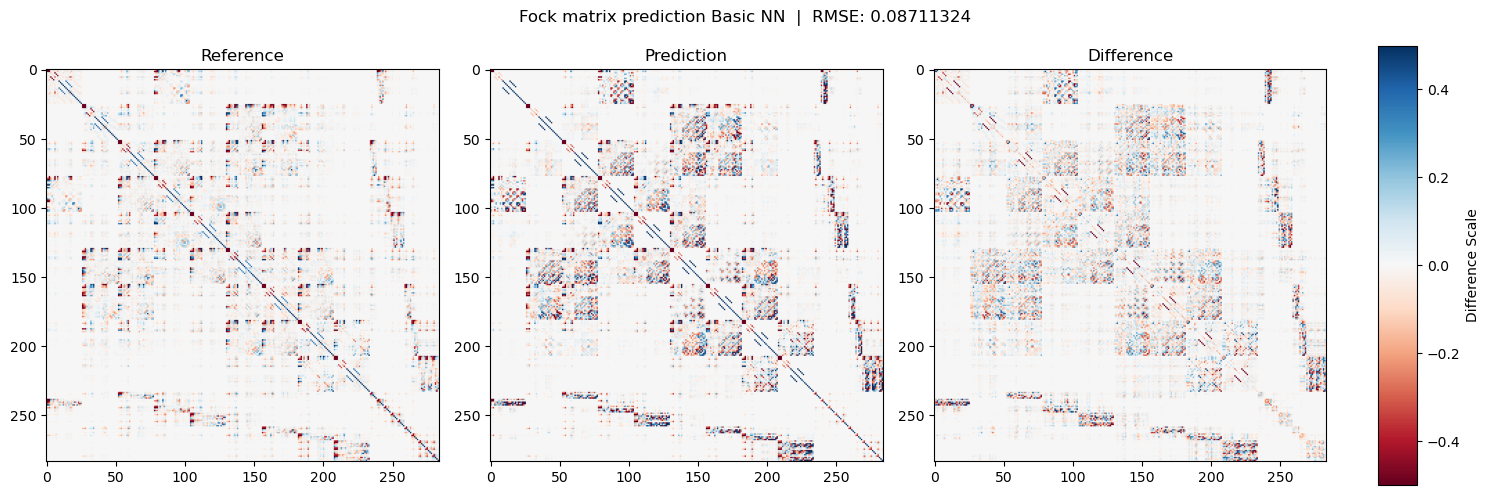

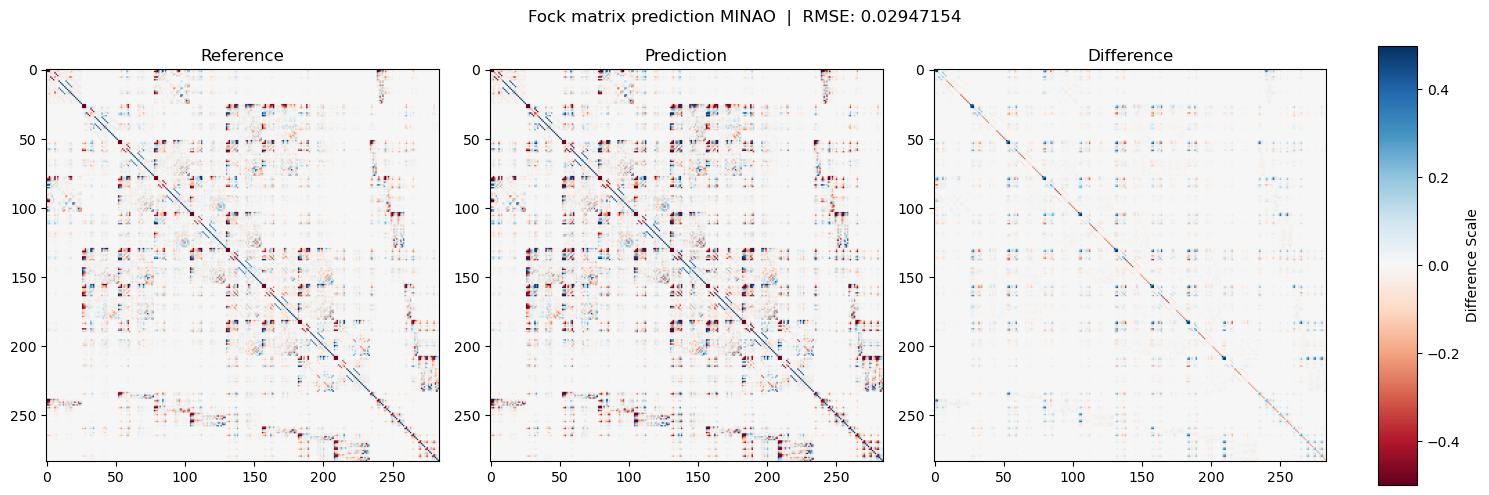

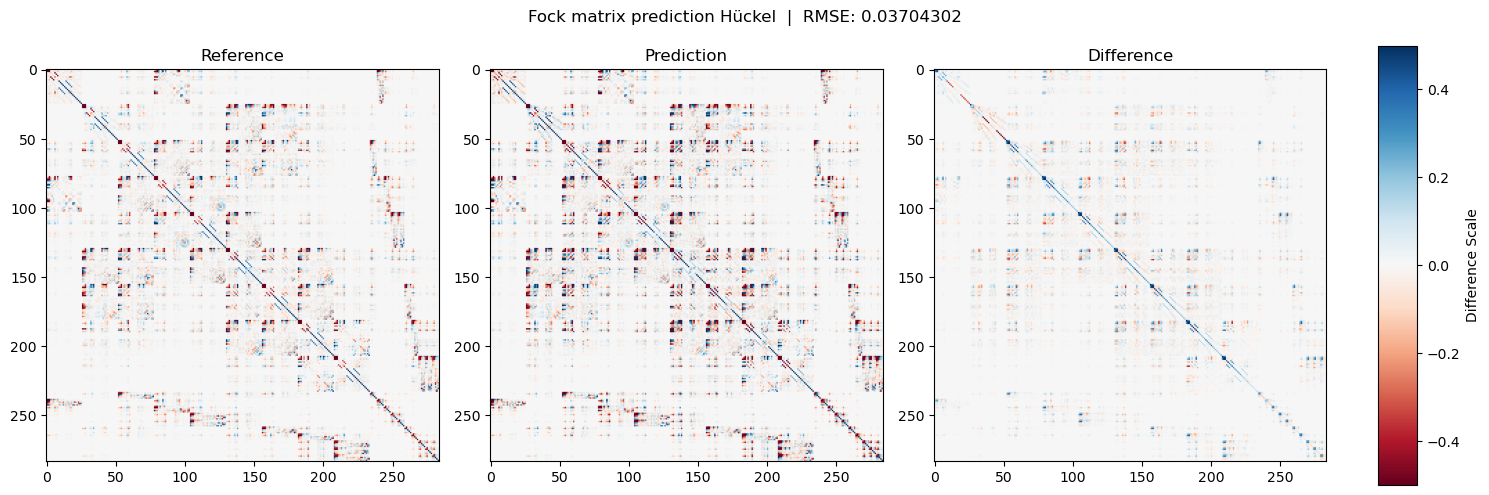

In [ ]:
# example comparison: 
rand_test_sample = np.random.randint(0, len(test_loader.file_paths) - 1)
# compare with hückel and minao
file_path = test_loader.file_paths[rand_test_sample]
print(basis)
test_mol = load(file_path, symmetry=False, basis = basis, backend=Backend.PY)
focks_ref, dens_ref, ovlps_ref, _ = load_cached(
    [file_path],
    cache_path,
    None,
)
ground_truth_fock    = focks_ref[0]
ground_truth_density = dens_ref[0]
S_test_mol                    = ovlps_ref[0]

minao_guess = guess(test_mol, method="hf", basis=basis, scheme="minao")
hueckel_guess = guess(test_mol, method="hf", basis=basis, scheme="huckel")

pred_flat_diag = test_pred_fock_diag[rand_test_sample]
pred_fock      = reconstruct_Fock(pred_flat_diag, S_test_mol)

nelec = test_mol.native.nelectron//2
pred_density_example = density_from_fock(pred_fock, S_test_mol, nelec)

plot_mat_comp(ground_truth_fock, pred_fock, title="Fock matrix prediction Basic NN", vmax=0.5)
plot_mat_comp(ground_truth_fock, minao_guess.fock().numpy, title="Fock matrix prediction MINAO", vmax=0.5)
plot_mat_comp(ground_truth_fock, hueckel_guess.fock().numpy, title="Fock matrix prediction Hückel", vmax=0.5)

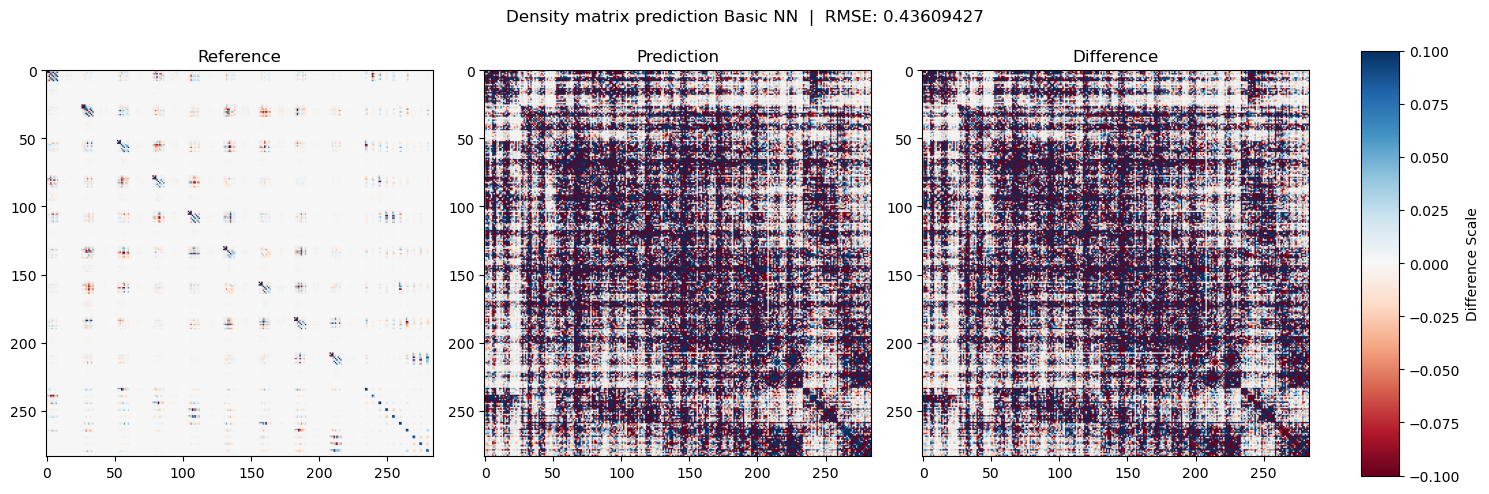

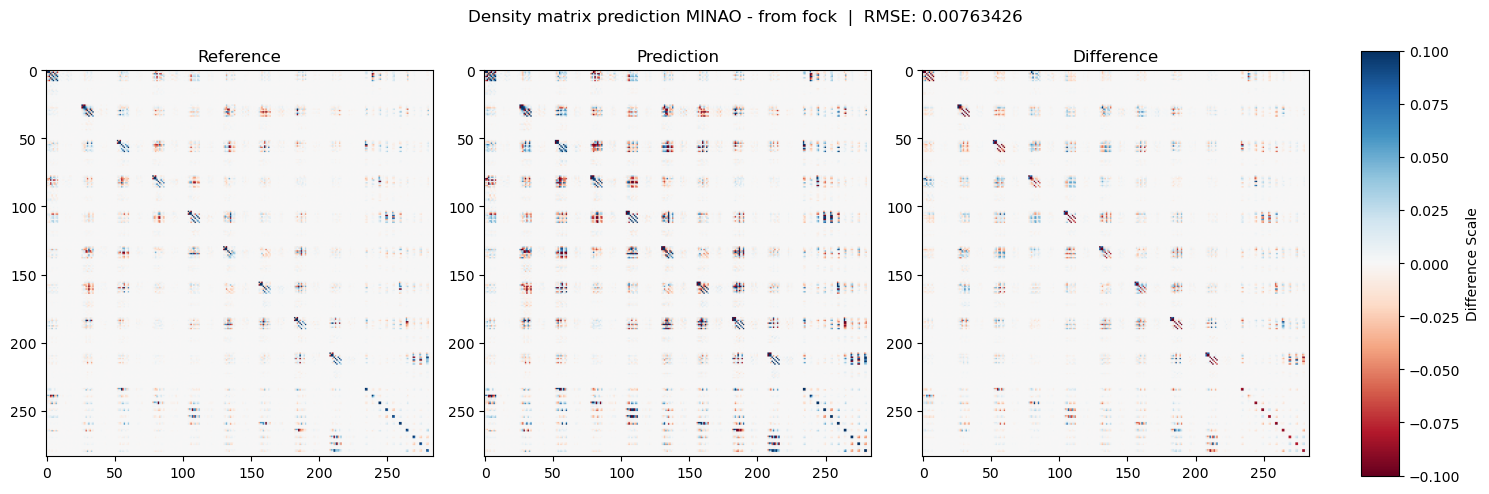

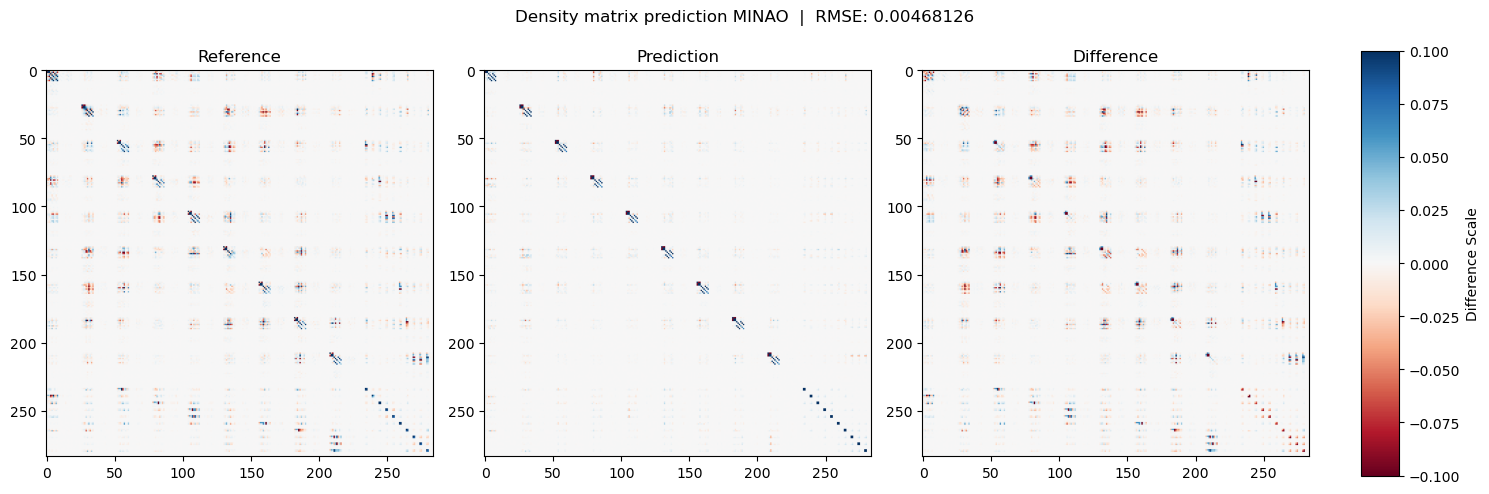

In [ ]:
density_from_fock_minao = density_from_fock(minao_guess.fock().numpy, S_test_mol, test_mol.native.nelectron//2)
plot_mat_comp(ground_truth_density, pred_density_example, title="Density matrix prediction Basic NN", vmax=0.1)
plot_mat_comp(ground_truth_density, density_from_fock_minao, title="Density matrix prediction MINAO - from fock", vmax=0.1)
plot_mat_comp(ground_truth_density, minao_guess.density().numpy, title="Density matrix prediction MINAO", vmax=0.1)

In [ ]:
# test sim
minao_res = calculate(test_mol, method="dft", functional="b3lypg", basis=basis, guess="minao")

Using basis from ../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.018114222422


In [ ]:
nn_res = perform_calculation(file_path, pred_density_example, method="dft", functional="b3lypg", basis_set=basis)

converged SCF energy = -423.01811422212


In [ ]:
print(nn_res["cycles"])


19


In [ ]:
print(minao_res.native.cycles)

11


# Test one iteration SCF

In [ ]:
import numpy as np
from pyscf import scf
from pyscf.lib.linalg_helper import eigh

def scf_one_iteration_from_minao(mol, D0=None):
    """
    Perform one SCF iteration starting from a MINAO guess.
    Returns the new density matrix D1 and the total energy E_tot.
    """
    mf = scf.RHF(mol)
    # 1) Get integrals and overlap
    S    = mf.get_ovlp()
    hcore = mf.get_hcore()
    e_nuc = mol.energy_nuc()
    if D0 is None: 
        # 2) Build MINAO guess density
        D0 = mf.get_init_guess(mol, key='minao')
    # 3) Build Fock from D0
    F0 = mf.get_fock(dm=D0)

    nocc   = mol.nelectron // 2
    D1 = density_from_fock(F0, S, nocc)
    # 7) Compute SCF energy: E_el = ½ Tr[D1 (hcore+F0)], E_tot = E_el + E_nuc
    e_el   = 0.5 * np.einsum('ij,ij', D1, hcore + F0)
    E_tot  = e_el + e_nuc

    return D1, E_tot, S, hcore, F0


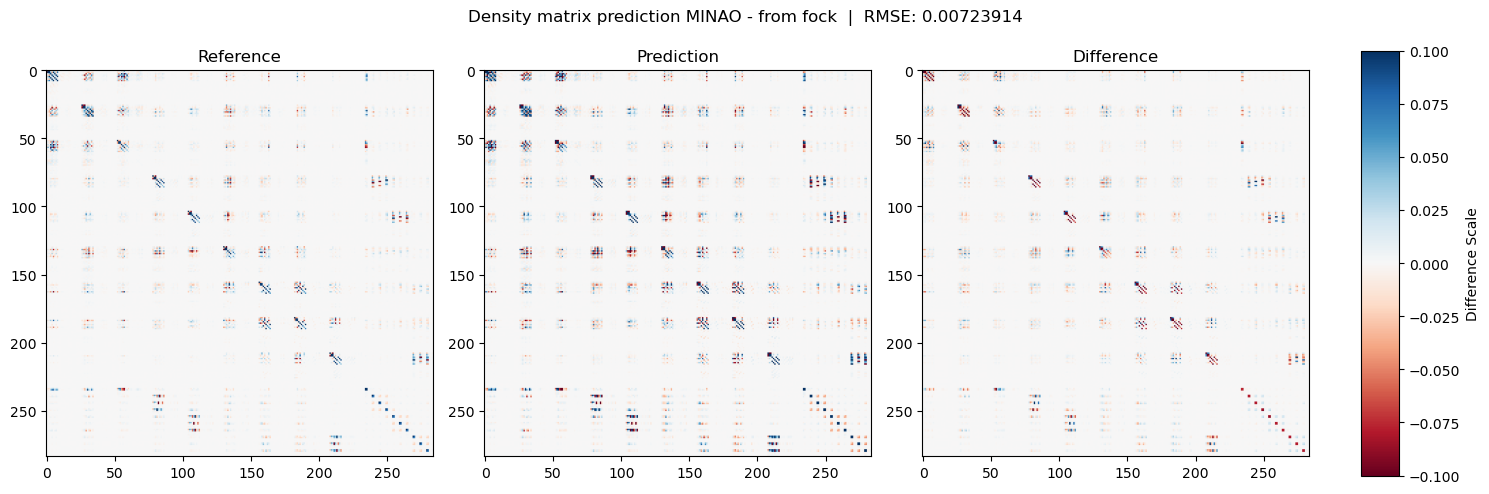

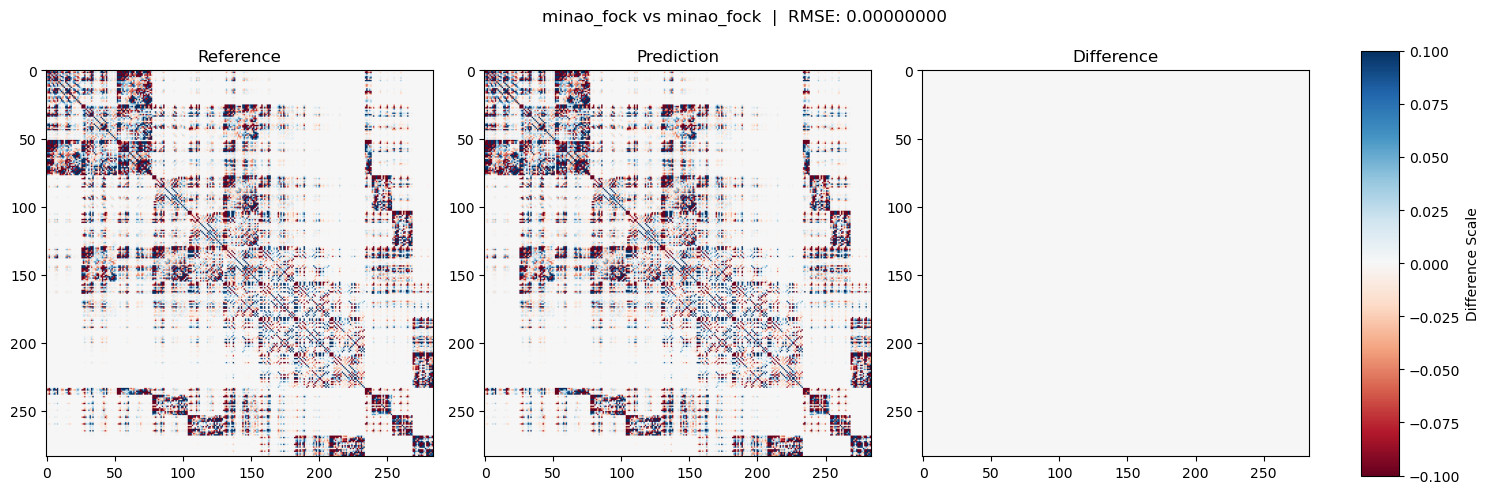

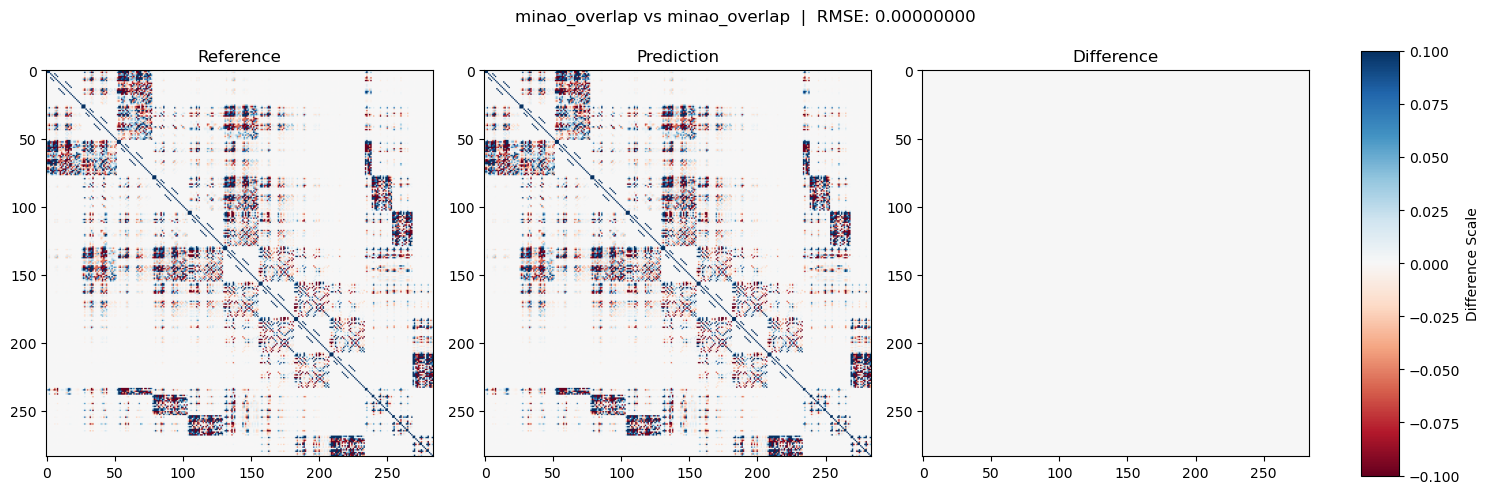

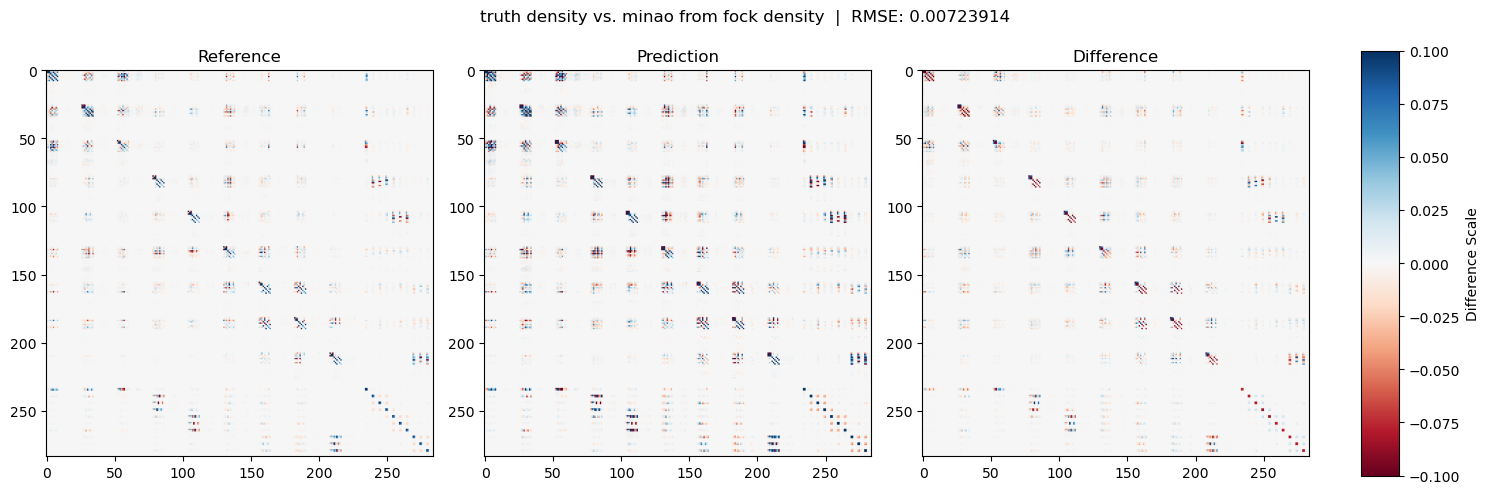

In [ ]:
d, e, S, hcore, F = scf_one_iteration_from_minao(test_mol.native)
plot_mat_comp(ground_truth_density_example, d, title="Density matrix prediction MINAO - from fock", vmax=0.1)
plot_mat_comp(minao_guess.fock().numpy, F, title="minao_fock vs minao_fock", vmax=0.1)
plot_mat_comp(minao_guess.overlap().numpy, S, title="minao_overlap vs minao_overlap", vmax=0.1)
density_from_minao_fock = density_from_fock(minao_guess.fock().numpy, minao_guess.overlap().numpy, test_mol.native.nelectron//2)
plot_mat_comp(ground_truth_density_example, density_from_minao_fock, title="truth density vs. minao from fock density", vmax=0.1)
